# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, plot_true_pred, plotComparisonShapleyValues, plotMultipleSV

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

In [4]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = {'Self-reported fluency level=native': 'fluency=native', \
                  'total_silence':'tot_silence', 'location': 'loc', \
                  'Current language used for work/school=English (United States)': 'lang=EN_US', \
                  'speakerId' : 'spkID', \
                  'First Language spoken=English (United States)':  'lang=EN_US', \
                  'trimmed':'trim', \
                  'total_':'', \
                  'speed_rate_word':'speakRate', \
                  'speed_rate_char':'speakCharRate', \
                  'change language': 'change lang', \
                  'duration': 'dur'}

abbreviations_shorter = abbreviations.copy()

# Util Functions

In [5]:
## Function for computing the percentage of error for the problematic speaker in a given slice
def percentage_problematic_speaker(df_sel, max_perc = 0.25, column = "prediction", groupby = "speakerId", problematic_speaker = "NgQEvO2x7Vh3xy2xz"):
    """ Check if source of error is for more that max_perc of the problematic speaker
        df_sel (pd.DataFrame) : dataset
        max_perc (float): max percentage.
    
        Returns bool, percentage_error: True if percentage of error of the problematic speaker in the slice is greater than threshold
    """
    df_sel_sk = df_sel.copy()
    if "speakerId" not in df_sel_sk.columns:
        df_sel_sk['speakerId'] = df_sel_sk.index.map(lambda x: x.split("/")[3])
    
    tot_prediction_count = dict(df_sel_sk[column].value_counts())
    if 0 not in tot_prediction_count:
        return False, 0
    tot_error_slice = tot_prediction_count[0]
    df_sel_i = df_sel_sk.loc[df_sel_sk[groupby] == problematic_speaker]
    if df_sel_i.shape[0]==0:
        return False, 0
    prediction_counts = dict(df_sel_i[column].value_counts())
    if 0 not in prediction_counts:
        return False, 0
    percentage_error = prediction_counts[0]/tot_error_slice
    return percentage_error > max_perc, percentage_error


In [6]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [7]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [8]:
## Function for substituting gender of a given itemset
substitute_gender = lambda x : "gender=male" if "gender=female" in x else ("gender=female" if "gender=male" in x else x)

# Define targets

In [9]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [10]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [11]:
## Columns of the df file that we are going to analyze 
demo_cols = ['Self-reported fluency level ', 'First Language spoken',
       'Current language used for work/school', 'gender', 'ageRange']

slot_cols = ['action', 'object', 'location']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + slot_cols + signal_cols 

# Retrieve Data and Compute Divergence

In [12]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [13]:
FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", f"FSC_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0 )
    df[target_col] = df[target_col]

    ## Add SpeakerID information if it is present in the df
    if "speakerId" in input_cols:
        df['speakerId'] = df.index.map(lambda x: x.split("/")[2])

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
        
    df_discretized.loc[df_discretized["location"]=="none_location", "location"] = "none"
    df_discretized.loc[df_discretized["object"]=="none_object", "object"] = "none"
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base
wav2vec2-large
hubert-base
hubert-large


In [14]:
## Check if the accuracy of the models is as expected
for config in ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict['wav2vec2-large'])
    print(f"Accuracy of {config}:", round(100*prediction,3))

Accuracy of wav2vec2-base: 91.722
Accuracy of wav2vec2-large: 93.172
Accuracy of hubert-base: 98.418
Accuracy of hubert-large: 98.497


In [15]:
## Check if the accuracy of the models is as expected
for config in ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]:
    print(config)
    print(filter_itemset_df_by_attributes(FP_fm_dict[config],['gender'], alls = True)\
        [['itemsets', 'accuracy', 'd_accuracy']]\
        .sort_values('d_accuracy', ascending = False))

wav2vec2-base
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.92510     0.00789
35    (gender=male)   0.90864    -0.00858
wav2vec2-large
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.95395     0.02223
35    (gender=male)   0.90754    -0.02418
hubert-base
           itemsets  accuracy  d_accuracy
31  (gender=female)   0.98735     0.00317
35    (gender=male)   0.98074    -0.00344
hubert-large
           itemsets  accuracy  d_accuracy
35    (gender=male)   0.98514     0.00017
31  (gender=female)   0.98482    -0.00015


# Divergence Wav2Vec2-Base

In [16]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [17]:
## Retrieve Most Divergent Itemsets 
n = 3

from copy import deepcopy
pr = FPdiv.head(n).copy()

pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

display(pr.head(n))

,support,itemsets,#errors,#corrects,accuracy,d_accuracy,t_value,support_count,length
44217,0.03,"(gender=male, speed_rate_word=high, ageRange=22-40, location=none, total_silence=high)",47,72,60.504,-31.217,7.05,119.0,5
32246,0.04,"(ageRange=22-40, total_silence=high, speed_rate_word=high, gender=male)",52,88,62.857,-28.864,7.13,140.0,4
39743,0.03,"(location=none, gender=male, trimmed_duration=low, n_words=low, total_silence=high)",45,80,64.000,-27.722,6.54,125.0,5


In [18]:
## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))

display(pr_l.head(3))

,itemsets,support,accuracy,d_accuracy,t_value
44217,"ageRange=22-40, gender=male, loc=none, speakRate=high, tot_silence=high",0.03,60.504,-31.217,7.05
32246,"ageRange=22-40, gender=male, speakRate=high, tot_silence=high",0.04,62.857,-28.864,7.13
39743,"gender=male, loc=none, n_words=low, tot_silence=high, trim_dur=low",0.03,64.000,-27.722,6.54


In [19]:
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

0 97.87
1 98.08
2 84.44


# Divergence Wav2Vec2-Large

In [20]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [21]:
## Retrieve Most Divergent Itemsets 
n = 3

from copy import deepcopy
pr = FPdiv.head(n).copy()

pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

display(pr.head(n))

,support,itemsets,#errors,#corrects,accuracy,d_accuracy,t_value,support_count,length
44217,0.03,"(gender=male, speed_rate_word=high, ageRange=22-40, location=none, total_silence=high)",30,89,74.790,-18.382,4.72,119.0,5
37151,0.03,"(action=increase, speed_rate_word=high, gender=male)",33,98,74.809,-18.362,4.94,131.0,3
27745,0.04,"(action=activate, speed_rate_word_trimmed=low, gender=male)",38,113,74.834,-18.337,5.27,151.0,3


In [22]:
## Choose columns for better visualization 
pr_l = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))

display(pr_l.head(3))

,itemsets,support,accuracy,d_accuracy,t_value
44217,"ageRange=22-40, gender=male, loc=none, speakRate=high, tot_silence=high",0.03,74.790,-18.382,4.72
37151,"action=increase, gender=male, speakRate=high",0.03,74.809,-18.362,4.94
27745,"action=activate, gender=male, speakRate_trim=low",0.04,74.834,-18.337,5.27


In [23]:
for e, itemset in enumerate(pr.itemsets):
    df_sel = slice_by_itemset(df_dict[config], itemset)
    
    _, percentage_problematic = percentage_problematic_speaker(df_sel)
    print(e, round(percentage_problematic*100,2))

0 96.67
1 54.55
2 44.74


# Divergence difference Wav2Vec2-Base vs Wav2Vec2-Large

In [24]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2l = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wlarge = FPdiv_w2l.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(wlarge, lsuffix='_base', rsuffix='_large')
merged = merged.rename(columns={'support_large': 'support'})

In [25]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_large"] - merged["accuracy_base"]
merged["difference"] = merged["accuracy_large"] - merged["accuracy_base"]

In [26]:
## Create "Gain Base-Large W2V2" df and compute divergence
base_large_gain_df = merged[['support', '#errors_large', '#corrects_large', 'accuracy_large',
       'd_accuracy_large', 't_value_large', 'support_count_large', 'length_large'] \
       + [diff, "difference", "accuracy_base"]]
base_large_gain_df = base_large_gain_df.rename(columns={'length_large':'length'})
base_large_gain_df = base_large_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(base_large_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [27]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_base', 'accuracy_large', 'support']

## Stats

In [28]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),4))

# Percentage of itemsets for which performance are greater for Wav2Vec2-Large
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 4))

# Percentage of itemsets for which performance are lower for Wav2Vec2-Large
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]), 4))

Equal
4.3573
Greater
63.7506
Lower
31.8921


## Gain > 0

In [29]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

display(pr)

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"(speed_rate_word_trimmed=low, trimmed_duration=low, location=none, action=increase, total_duration=low)",22.69,75.63,98.32,0.03
1,"(trimmed_duration=low, ageRange=22-40, location=none, action=increase, total_duration=low)",22.01,70.44,92.45,0.04
2,"(trimmed_duration=low, ageRange=22-40, object=volume, action=increase, total_duration=low)",21.93,70.18,92.10,0.03
3,"(location=none, action=increase, total_duration=low, speed_rate_word_trimmed=low)",21.88,76.56,98.44,0.03
4,"(location=none, trimmed_duration=low, ageRange=22-40, n_words=low, action=increase, total_duration=low)",20.66,69.42,90.08,0.03
5,"(gender=female, location=none, trimmed_duration=low, n_words=low, action=increase)",20.32,68.29,88.62,0.03
6,"(speed_rate_word_trimmed=low, action=increase, total_duration=low, trimmed_duration=low)",19.85,78.68,98.53,0.04
7,"(location=none, gender=female, action=increase, total_duration=low)",19.35,74.19,93.55,0.03
8,"(ageRange=22-40, object=volume, total_duration=low, trimmed_duration=low)",18.97,71.80,90.77,0.05
9,"(ageRange=22-40, action=increase, total_duration=low, trimmed_duration=low)",18.82,74.73,93.55,0.05


In [30]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"action=increase, loc=none, speakRate_trim=low, dur=low, trim_dur=low",22.69,75.63,98.32,0.03
1,"action=increase, ageRange=22-40, loc=none, dur=low, trim_dur=low",22.01,70.44,92.45,0.04


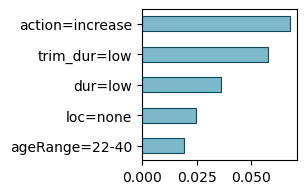

In [31]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[1].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Gain < 0 

In [32]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

pr

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"(action=activate, speed_rate_word=low, gender=male)",-20.97,96.77,75.81,0.03
1,"(action=activate, speed_rate_word_trimmed=low, gender=male)",-16.56,91.39,74.83,0.04
2,"(action=activate, n_words=medium, gender=male)",-16.39,94.54,78.14,0.05
3,"(location=washroom, action=activate, n_words=medium)",-16.26,96.75,80.49,0.03
4,"(speed_rate_word=low, object=lights, action=activate, n_words=medium)",-16.13,99.19,83.06,0.03
5,"(action=activate, trimmed_duration=medium, gender=male)",-16.03,95.42,79.39,0.03
6,"(object=lights, location=washroom, gender=male)",-15.65,95.65,80.00,0.03
7,"(gender=male, action=activate, total_silence=low)",-15.54,93.92,78.38,0.04
8,"(object=lights, action=activate, trimmed_duration=medium, gender=male)",-15.45,95.12,79.68,0.03
9,"(object=lights, action=activate, speed_rate_word=low, total_silence=low)",-15.44,96.32,80.88,0.04


In [33]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support
0,"action=activate, gender=male, speakRate=low",-20.97,96.77,75.81,0.03
1,"action=activate, gender=male, speakRate_trim=low",-16.56,91.39,74.83,0.04


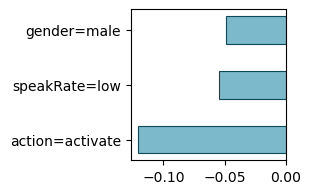

In [34]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Gain = 0 

In [35]:
## Retrieve the data cohorts for which Wav2Vec2-Large performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support_large"] = pr["support"].round(2)
pr["accuracy_large"] = (pr["accuracy_large"]*100).round(2)
pr["accuracy_base"] = (pr["accuracy_base"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

pr = pr.sort_values("d_difference").sort_values("accuracy_large")
pr.head(20)

,itemsets,d_difference,accuracy_base,accuracy_large,support,support_large
3167,"(n_words=low, action=increase, speed_rate_word=high, gender=male)",0.0,75.41,75.41,0.032165,0.03
3166,"(n_words=low, object=volume, action=increase, gender=male)",0.0,78.15,78.15,0.031374,0.03
3165,"(ageRange=22-40, action=activate, total_silence=high)",0.0,84.77,84.77,0.039810,0.04
3164,"(n_words=low, action=activate, total_duration=low)",0.0,84.85,84.85,0.034801,0.03
3163,"(total_duration=low, total_silence=medium, speed_rate_word=high, gender=male)",0.0,86.86,86.86,0.036119,0.04
3162,"(location=none, total_silence=medium, speed_rate_word=high, gender=male)",0.0,87.16,87.16,0.039019,0.04
3161,"(n_words=low, total_duration=low, total_silence=medium, gender=male)",0.0,87.34,87.34,0.041656,0.04
3160,"(action=increase, trimmed_duration=medium, n_words=medium)",0.0,87.72,87.72,0.030055,0.03
3159,"(speed_rate_word_trimmed=medium, total_duration=low, total_silence=medium)",0.0,88.19,88.19,0.033483,0.03
3158,"(location=none, speed_rate_word_trimmed=medium, total_duration=low, gender=male)",0.0,88.33,88.33,0.047456,0.05


In [36]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_base,accuracy_large,support,support_large
3167,"action=increase, gender=male, n_words=low, speakRate=high",0.0,75.41,75.41,0.032165,0.03
3166,"action=increase, gender=male, n_words=low, object=volume",0.0,78.15,78.15,0.031374,0.03


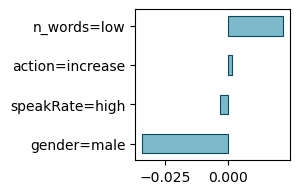

In [37]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Inspect gender

We consider subgroups among the top-10 of each gain category for which both two genders are above support.

In [38]:
n = 20
cols = ['d_difference','accuracy_base', 'accuracy_large', 'support']
comparison_res = []
config1 = "wav2vec2-base"
config2 = "wav2vec2-large"

In [39]:
## Compute gain in performance when size changes, when considering different genders
great = compare_performance[cols].head(n).reset_index()
notr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
equal = notr.loc[notr[diff]==0].sort_values('accuracy_large').head(n)
low = compare_performance[cols][::-1].head(n).reset_index()

for gain_type, pr in zip(['>', "=", "<"], [great, equal, low]):
    gain_df_gender = filter_itemset_df_by_attributes(pr, ['gender'], alls=False)

    itemsets = gain_df_gender.itemsets.values

    config1 = "wav2vec2-base"
    config2 = "wav2vec2-large"
    get_accuracy = lambda dfi: sum(dfi['prediction'].values.astype(int))/len(dfi)
    get_support_count = lambda dfi: len(dfi)

    res2 = []
    res = []

    genders = ['gender=female', 'gender=male']
    configs = [config1, config2]
    for itemset_i in itemsets:
        itemset_i = itemset_i.difference(genders)
        r2 = [gain_type, itemset_i]
        both_genders = []
        both_genders_2 = []
        for gender in genders:
            itemset = itemset_i.union([gender])
            r = [gain_type, itemset]

            for config in configs:
                if itemset in  fp_divergence_dict[config].itemset_divergence[len(itemset)]:
                    info = fp_divergence_dict[config].getInfoItemset(itemset).iloc[0]
                    acc = info["accuracy"]
                    s = info["support_count"]

                    r.append((acc*100).round(2))
                    r2.append((acc*100).round(2))
                    r.append(s)

            if len(r)>2:
                r2.append(s)
                both_genders.append(r)
                both_genders_2.append(r2)

        if len(both_genders)==2:
            for r in both_genders:
                res.append(r)
            res2.append(r2)
    
    cols =[]
    for gender in genders:
        cols.extend([f"{c}_{gender}" for c in configs + ["sup"]])
    v = pd.DataFrame(res, columns = ['Gain',"Subgroup"] + configs + ["S1", "S2"])
    v2 = pd.DataFrame(res2, columns = ['Gain', "Subgroup"] + cols )

    comparison_res.append(v2)

comparison_res = pd.concat(comparison_res)
comparison_res

,Gain,Subgroup,wav2vec2-base_gender=female,wav2vec2-large_gender=female,sup_gender=female,wav2vec2-base_gender=male,wav2vec2-large_gender=male,sup_gender=male
0,>,"(n_words=low, location=none, action=increase, trimmed_duration=low)",68.29,88.62,123.0,73.48,81.82,132.0
1,>,"(location=none, action=increase, total_duration=low)",74.19,93.55,124.0,78.74,89.08,174.0
0,=,"(n_words=low, action=increase, speed_rate_word=high)",78.41,90.91,176.0,75.41,75.41,122.0
1,=,"(n_words=low, object=volume, action=increase)",73.44,89.84,128.0,78.15,78.15,119.0
2,=,"(total_duration=low, total_silence=medium, speed_rate_word=high)",85.71,95.65,161.0,86.86,86.86,137.0
3,=,"(location=none, total_silence=medium, speed_rate_word=high)",90.08,95.80,262.0,87.16,87.16,148.0
4,=,"(n_words=low, total_duration=low, total_silence=medium)",85.55,95.38,173.0,87.34,87.34,158.0
5,=,"(location=none, speed_rate_word_trimmed=medium, total_duration=low)",84.13,94.44,126.0,88.33,88.33,180.0
6,=,"(speed_rate_word_trimmed=low, speed_rate_word=medium)",91.82,94.34,159.0,90.05,90.05,211.0
7,=,"(n_words=low, action=decrease)",91.37,91.37,197.0,82.90,92.75,193.0


In [40]:
## Select columns for better visualization
comparison_res_pr = comparison_res.copy()

comparison_res_pr['Subgroup_str'] = comparison_res_pr['Subgroup'].apply(lambda x: sortItemset(x, abbreviations))

comparison_res_pr = comparison_res_pr[['Gain', 'Subgroup_str', 
       'wav2vec2-base_gender=female', 'wav2vec2-large_gender=female',
       'wav2vec2-base_gender=male', 'wav2vec2-large_gender=male', 
       'sup_gender=female', 'sup_gender=male']]

comparison_res_pr

,Gain,Subgroup_str,wav2vec2-base_gender=female,wav2vec2-large_gender=female,wav2vec2-base_gender=male,wav2vec2-large_gender=male,sup_gender=female,sup_gender=male
0,>,"action=increase, loc=none, n_words=low, trim_dur=low",68.29,88.62,73.48,81.82,123.0,132.0
1,>,"action=increase, loc=none, dur=low",74.19,93.55,78.74,89.08,124.0,174.0
0,=,"action=increase, n_words=low, speakRate=high",78.41,90.91,75.41,75.41,176.0,122.0
1,=,"action=increase, n_words=low, object=volume",73.44,89.84,78.15,78.15,128.0,119.0
2,=,"speakRate=high, dur=low, tot_silence=medium",85.71,95.65,86.86,86.86,161.0,137.0
3,=,"loc=none, speakRate=high, tot_silence=medium",90.08,95.80,87.16,87.16,262.0,148.0
4,=,"n_words=low, dur=low, tot_silence=medium",85.55,95.38,87.34,87.34,173.0,158.0
5,=,"loc=none, speakRate_trim=medium, dur=low",84.13,94.44,88.33,88.33,126.0,180.0
6,=,"speakRate=medium, speakRate_trim=low",91.82,94.34,90.05,90.05,159.0,211.0
7,=,"action=decrease, n_words=low",91.37,91.37,82.90,92.75,197.0,193.0


In [41]:
comparison_res_pr['wav2vec2-base_performance_diff'] = comparison_res_pr['wav2vec2-base_gender=female'] - comparison_res_pr['wav2vec2-base_gender=male']
comparison_res_pr['wav2vec2-large_performance_diff'] = comparison_res_pr['wav2vec2-large_gender=female'] - comparison_res_pr['wav2vec2-large_gender=male']

In [42]:
comparison_res_pr.sort_values('wav2vec2-large_performance_diff', ascending=False)

,Gain,Subgroup_str,wav2vec2-base_gender=female,wav2vec2-large_gender=female,wav2vec2-base_gender=male,wav2vec2-large_gender=male,sup_gender=female,sup_gender=male,wav2vec2-base_performance_diff,wav2vec2-large_performance_diff
0,<,"action=activate, n_words=medium",96.17,95.22,94.54,78.14,209.0,183.0,1.63,17.08
2,<,"loc=washroom, object=lights",96.58,96.58,95.65,80.00,117.0,115.0,0.93,16.58
3,<,"action=activate, n_words=medium, object=lights",97.63,95.27,94.08,78.95,169.0,152.0,3.55,16.32
0,=,"action=increase, n_words=low, speakRate=high",78.41,90.91,75.41,75.41,176.0,122.0,3.00,15.50
1,<,"action=activate, trim_dur=medium",97.71,94.66,95.42,79.39,131.0,131.0,2.29,15.27
1,=,"action=increase, n_words=low, object=volume",73.44,89.84,78.15,78.15,128.0,119.0,-4.71,11.69
2,=,"speakRate=high, dur=low, tot_silence=medium",85.71,95.65,86.86,86.86,161.0,137.0,-1.15,8.79
3,=,"loc=none, speakRate=high, tot_silence=medium",90.08,95.80,87.16,87.16,262.0,148.0,2.92,8.64
4,=,"n_words=low, dur=low, tot_silence=medium",85.55,95.38,87.34,87.34,173.0,158.0,-1.79,8.04
0,>,"action=increase, loc=none, n_words=low, trim_dur=low",68.29,88.62,73.48,81.82,123.0,132.0,-5.19,6.80


In [43]:
## Choose the top itemset for each gain value (i.e., >, <, =)
comparison_top_1 = comparison_res_pr.loc[[0]]
comparison_top_1 = comparison_top_1.sort_values("Gain", ascending=False)
comparison_top_1

,Gain,Subgroup_str,wav2vec2-base_gender=female,wav2vec2-large_gender=female,wav2vec2-base_gender=male,wav2vec2-large_gender=male,sup_gender=female,sup_gender=male,wav2vec2-base_performance_diff,wav2vec2-large_performance_diff
0,>,"action=increase, loc=none, n_words=low, trim_dur=low",68.29,88.62,73.48,81.82,123.0,132.0,-5.19,6.80
0,=,"action=increase, n_words=low, speakRate=high",78.41,90.91,75.41,75.41,176.0,122.0,3.00,15.50
0,<,"action=activate, n_words=medium",96.17,95.22,94.54,78.14,209.0,183.0,1.63,17.08


#### Shapley value

In [44]:
height = 0.45
sizeFig = (6.5,2.5)
labelsize = 13.3
pad = 3

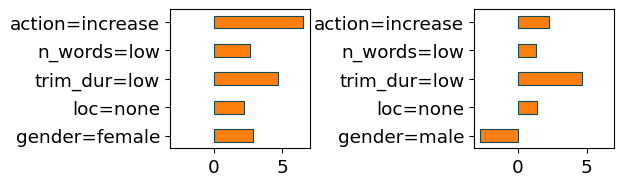

In [45]:
## Plot for paper 
itemset = comparison_res.loc[0].iloc[0]['Subgroup']

itemset_shaps = []
for gender in genders:
    itemset_0 = itemset.union([gender])
    itemset_shaps.append(fp_divergence_difference.computeShapleyValue(itemset_0))

# Sort "gender = female"
sorted_dict_1 = {}
tmp = {}
for key,value in itemset_shaps[0].items():
    if "male" in str(key):
        sorted_dict_1[key] = value
    else:
        tmp[key] = value
for key,value in tmp.items():
    sorted_dict_1[key] = value

# Sort "gender = male"
sorted_dict_2 = {}
tmp = {}
for key,value in itemset_shaps[1].items():
    if "male" in str(key):
        sorted_dict_2[key] = value
    else:
        tmp[key] = value
for key,value in tmp.items():
    sorted_dict_2[key] = value

name_fig = f"plot_results/comparison_shapley_w2b_w2l"
        
plotComparisonShapleyValues(abbreviateDict(sorted_dict_1, abbreviations), \
                            abbreviateDict(sorted_dict_2, abbreviations), \
                            sizeFig=sizeFig, sharedAxis=True, sort="paper", \
                            height = height, saveFig=True, subcaption=False, \
                            nameFig=name_fig, labelsize=labelsize, pad=pad)

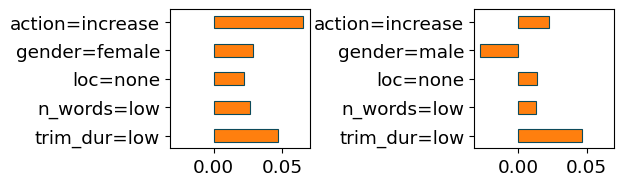

In [46]:
## Plot Shapley Values for the first just-retrieved data subgroup
itemset = comparison_res.loc[0].iloc[0]['Subgroup']

itemset_shaps = []
for gender in genders:
    itemset_0 = itemset.union([gender])
    itemset_shaps.append(fp_divergence_difference.computeShapleyValue(itemset_0))
                
plotComparisonShapleyValues(abbreviateDict(itemset_shaps[0], abbreviations), \
                            abbreviateDict(itemset_shaps[1], abbreviations), \
                            sizeFig=sizeFig, sharedAxis=True, sort="alp", \
                            height = height, saveFig=False, subcaption=False, \
                            labelsize=labelsize, pad=pad) 

## Global Shapley value

In [47]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_w2l = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_w2l = {k:v for k,v in global_item_divergence_w2b_w2l.items() \
                        if k in sorted(global_item_divergence_w2b_w2l, 
                        key=lambda x: abs(global_item_divergence_w2b_w2l[x]))[::-1][:K]}

In [48]:
from utils_analysis import plotShapleyValue

sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

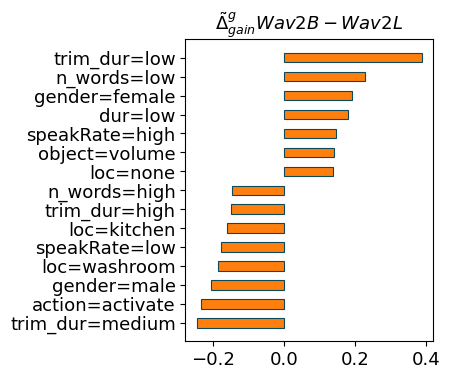

In [49]:
## Plot and Save the image 
topK_global_w2b_w2l_abbr = abbreviateDict(topK_global_w2b_w2l, abbreviations )

plotShapleyValue(shapley_values=topK_global_w2b_w2l_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - Wav2L$", saveFig=False)

# Divergence difference Wav2Vec2-Base vs Hubert-Base

In [50]:
## Compute the divergence for Hubert-Base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_hb = fp_divergence_i.getDivergence(th_redundancy=None).copy()
hbase = FPdiv_hb.set_index("itemsets")

## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]
FPdiv_w2b = fp_divergence_i.getDivergence(th_redundancy=None).copy()
wbase = FPdiv_w2b.set_index("itemsets")

## Merge the df
merged = wbase.join(hbase, lsuffix='_w2b', rsuffix='_hb')
merged = merged.rename(columns={'support_hb': 'support'})

In [51]:
## Compute difference in performance between the models
diff = "d_difference"
merged[diff] = merged["accuracy_hb"] - merged["accuracy_w2b"]
merged["difference"] = merged["accuracy_hb"] - merged["accuracy_w2b"]

In [52]:
## Create "Gain W2Base-HBase" df and compute divergence
hbase_w2base_gain_df = merged[['support', '#errors_hb', '#corrects_hb', 'accuracy_hb',
       'd_accuracy_hb', 't_value_hb', 'support_count_hb', 'length_hb'] \
       + [diff, "difference", "accuracy_w2b"]]
hbase_w2base_gain_df = hbase_w2base_gain_df.rename(columns={'length_hb':'length'})
hbase_w2base_gain_df = hbase_w2base_gain_df.reset_index()

fp_divergence_difference = FP_Divergence(hbase_w2base_gain_df, diff)
diff_nr = fp_divergence_difference.getDivergence(th_redundancy=0.0) 

In [53]:
## Select meaningful columns 
sel = diff_nr.itemsets.values
compare_performance = merged.loc[sel].sort_values(diff, ascending = False)
cols = ['d_difference', 'accuracy_w2b', 'accuracy_hb', 'support']

## Stats

In [54]:
## Compute meaningful statistics:
diff_nr_0 = fp_divergence_difference.getDivergence(th_redundancy=None)

# Percentage of itemsets for which performance are equal for the two model
print("Equal")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])==0].shape[0]/diff_nr_0.shape[0]),3))

# Percentage of itemsets for which performance are greater for Hubert-Base
print("Greater")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])>0].shape[0]/diff_nr_0.shape[0]), 3))

# Percentage of itemsets for which performance are lower for Hubert-Base
print("Lower")
print(round(100*(diff_nr_0.loc[(diff_nr_0[diff])<0].shape[0]/diff_nr_0.shape[0]),3))

Equal
1.927
Greater
97.034
Lower
1.039


## Gain > 0

In [55]:
## Retrieve the data cohorts for which Hubert-Base performs better than Wav2Vec2-Base
pr = compare_performance[cols].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

display(pr)

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
0,"(location=none, gender=male, trimmed_duration=low, n_words=low, total_silence=high)",31.20,64.00,95.20,0.03
1,"(gender=male, trimmed_duration=low, ageRange=22-40, object=volume, n_words=low)",31.11,67.41,98.52,0.04
2,"(location=none, gender=male, speed_rate_word=high, trimmed_duration=low, n_words=low, total_silence=high)",30.89,64.23,95.12,0.03
3,"(ageRange=22-40, object=volume, speed_rate_word=high, gender=male)",30.77,67.52,98.29,0.03
4,"(n_words=low, trimmed_duration=low, total_silence=high, gender=male)",30.77,65.04,95.80,0.04
5,"(gender=male, speed_rate_word=high, trimmed_duration=low, n_words=low, total_silence=high)",30.50,65.25,95.74,0.04
6,"(ageRange=22-40, object=volume, trimmed_duration=low, gender=male)",30.19,68.55,98.74,0.04
7,"(speed_rate_word_trimmed=high, speed_rate_word=high, object=volume, n_words=low, action=increase)",30.17,68.10,98.28,0.03
8,"(gender=male, speed_rate_word=high, ageRange=22-40, location=none, total_silence=high)",29.41,60.50,89.92,0.03
9,"(gender=male, speed_rate_word=high, trimmed_duration=low, location=none, total_silence=high)",29.32,64.66,93.98,0.04


In [56]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
0,"gender=male, loc=none, n_words=low, tot_silence=high, trim_dur=low",31.20,64.00,95.20,0.03
1,"ageRange=22-40, gender=male, n_words=low, object=volume, trim_dur=low",31.11,67.41,98.52,0.04


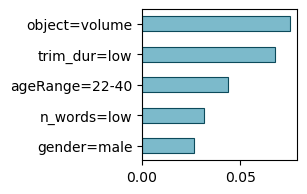

In [57]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[1].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Gain < 0 

In [58]:
## Retrieve the data cohorts for which Hubert-Base performs worse than Wav2Vec2-Base
pr = compare_performance[cols][::-1].head(20).reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)

pr

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
0,"(action=decrease, location=washroom, ageRange=22-40)",-1.68,100.00,98.32,0.03
1,"(action=decrease, gender=female, total_duration=high, total_silence=high)",-0.88,98.25,97.37,0.03
2,"(trimmed_duration=high, gender=male, speed_rate_word=low, action=decrease)",-0.86,100.00,99.14,0.03
3,"(trimmed_duration=high, location=washroom, object=heat, total_silence=medium)",-0.85,98.29,97.44,0.03
4,"(gender=male, trimmed_duration=high, n_words=high, speed_rate_word=low, location=none)",-0.85,99.15,98.29,0.03
5,"(location=washroom, n_words=high, action=increase, speed_rate_word=low)",-0.85,99.15,98.30,0.03
6,"(action=decrease, object=volume, ageRange=41-65)",-0.84,97.48,96.64,0.03
7,"(location=none, n_words=high, speed_rate_word=low, gender=male)",-0.83,99.17,98.33,0.03
8,"(n_words=high, ageRange=41-65, speed_rate_word=low, gender=male)",-0.83,100.00,99.17,0.03
9,"(gender=male, object=heat, action=decrease, n_words=high, speed_rate_word=low)",-0.83,100.00,99.17,0.03


In [59]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
0,"action=decrease, ageRange=22-40, loc=washroom",-1.68,100.00,98.32,0.03
1,"action=decrease, gender=female, dur=high, tot_silence=high",-0.88,98.25,97.37,0.03


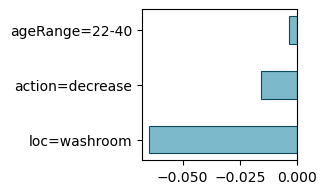

In [60]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Gain = 0 

In [61]:
## Retrieve the data cohorts for which Hubert-Base performs equal to Wav2Vec2-Base
pr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
pr["support"] = pr["support"].round(2)
pr["accuracy_hb"] = (pr["accuracy_hb"]*100).round(2)
pr["accuracy_w2b"] = (pr["accuracy_w2b"]*100).round(2)
pr["d_difference"] = (pr["d_difference"]*100).round(2)
pr = pr.loc[abs(pr["d_difference"])==0]

pr = pr.sort_values("d_difference").sort_values("accuracy_hb")
pr.head(20)

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
4785,"(action=decrease, n_words=high, speed_rate_word_trimmed=medium)",0.0,95.49,95.49,0.04
4784,"(action=decrease, trimmed_duration=high, speed_rate_word_trimmed=medium)",0.0,96.23,96.23,0.04
4783,"(action=decrease, n_words=high, total_duration=high, gender=female)",0.0,96.43,96.43,0.04
4782,"(action=decrease, gender=male, object=heat, total_silence=low)",0.0,96.97,96.97,0.03
4781,"(action=decrease, gender=female, trimmed_duration=high, total_duration=high)",0.0,97.13,97.13,0.05
4780,"(trimmed_duration=high, action=increase, speed_rate_word_trimmed=low, speed_rate_word=low)",0.0,97.18,97.18,0.04
4779,"(action=decrease, ageRange=22-40, object=heat, total_silence=low)",0.0,97.30,97.30,0.04
4778,"(ageRange=22-40, object=heat, speed_rate_word_trimmed=medium, total_silence=low)",0.0,97.44,97.44,0.03
4777,"(action=decrease, n_words=high, ageRange=22-40, total_duration=high)",0.0,97.50,97.50,0.03
4776,"(trimmed_duration=high, ageRange=22-40, action=increase, speed_rate_word=low)",0.0,97.50,97.50,0.04


In [62]:
## Abbreviate itemset names for better visualization
pr_l = pr.head(2).copy()
pr_l['itemsets'] = pr_l['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l

,itemsets,d_difference,accuracy_w2b,accuracy_hb,support
4785,"action=decrease, n_words=high, speakRate_trim=medium",0.0,95.49,95.49,0.04
4784,"action=decrease, speakRate_trim=medium, trim_dur=high",0.0,96.23,96.23,0.04


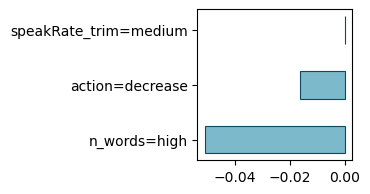

In [63]:
## Compute Shapley Values for a given itemset
itemset_1 = pr.iloc[0].itemsets
itemset_shap = fp_divergence_difference.computeShapleyValue(itemset_1)
fp_divergence_difference.plotShapleyValue(shapley_values=abbreviateDict(itemset_shap, abbreviations), 
                                          sizeFig=(2,2))

## Inspect gender

We consider subgroups among the top-10 of each gain category for which both two genders are above support.

In [64]:
n = 40
cols = ['d_difference','accuracy_w2b', 'accuracy_hb', 'support']
comparison_res = []
config1 = "wav2vec2-base"
config2 = "hubert-base"

In [65]:
## Compute gain in performance from Wav2Vec2-Base to Hubert-Base, when considering different genders
great = compare_performance[cols].head(n).reset_index()
notr = merged.loc[ fp_divergence_difference.getDivergence(th_redundancy=0.0).itemsets.values][cols].reset_index()
equal = notr.loc[notr[diff]==0].sort_values('accuracy_hb').head(n)
low = compare_performance[cols][::-1].head(n).reset_index()

for gain_type, pr in zip(['>', "=", "<"], [great, equal, low]):
    gain_df_gender = filter_itemset_df_by_attributes(pr, ['gender'], alls=False)

    itemsets = gain_df_gender.itemsets.values

    get_accuracy = lambda dfi: sum(dfi['prediction'].values.astype(int))/len(dfi)
    get_support_count = lambda dfi: len(dfi)

    res2 = []
    res = []

    genders = ['gender=female', 'gender=male']
    configs = [config1, config2]
    for itemset_i in itemsets:
        itemset_i = itemset_i.difference(genders)
        r2 = [gain_type, itemset_i]
        both_genders = []
        both_genders_2 = []
        for gender in genders:
            itemset = itemset_i.union([gender])
            r = [gain_type, itemset]

            for config in configs:
                if itemset in  fp_divergence_dict[config].itemset_divergence[len(itemset)]:
                    info = fp_divergence_dict[config].getInfoItemset(itemset).iloc[0]
                    acc = info["accuracy"]
                    s = info["support_count"]

                    r.append((acc*100).round(2))
                    r2.append((acc*100).round(2))
                    r.append(s)


            if len(r)>2:
                r2.append(s)
                both_genders.append(r)
                both_genders_2.append(r2)

        if len(both_genders)==2:
            for r in both_genders:
                res.append(r)
            res2.append(r2)
    
    cols =[]
    for gender in genders:
        cols.extend([f"{c}_{gender}" for c in configs + ["sup"]])
    v = pd.DataFrame(res, columns = ['Gain',"Subgroup"] + configs + ["S1", "S2"])
    v2 = pd.DataFrame(res2, columns = ['Gain', "Subgroup"] + cols )

    comparison_res.append(v2)

comparison_res = pd.concat(comparison_res)
comparison_res

,Gain,Subgroup,wav2vec2-base_gender=female,hubert-base_gender=female,sup_gender=female,wav2vec2-base_gender=male,hubert-base_gender=male,sup_gender=male
0,>,"(n_words=low, location=none, total_silence=high, trimmed_duration=low)",80.70,97.66,171.0,64.00,95.20,125.0
1,>,"(n_words=low, total_silence=high, location=none, speed_rate_word=high, trimmed_duration=low)",80.70,97.66,171.0,64.23,95.12,123.0
2,>,"(ageRange=22-40, object=volume, speed_rate_word=high)",83.33,96.80,156.0,67.52,98.29,117.0
3,>,"(n_words=low, trimmed_duration=low, total_silence=high)",83.33,97.98,198.0,65.04,95.80,143.0
4,>,"(total_silence=high, n_words=low, speed_rate_word=high, trimmed_duration=low)",83.33,97.98,198.0,65.25,95.74,141.0
5,>,"(ageRange=22-40, total_silence=high, location=none, speed_rate_word=high)",91.07,98.21,168.0,60.50,89.92,119.0
6,>,"(total_silence=high, location=none, speed_rate_word=high, trimmed_duration=low)",82.54,97.88,189.0,64.66,93.98,133.0
7,>,"(total_silence=high, trimmed_duration=low, speed_rate_word=high)",84.72,98.15,216.0,65.56,94.70,151.0
8,>,"(ageRange=22-40, n_words=low, location=none, speed_rate_word=high, trimmed_duration=low)",84.18,96.04,177.0,67.63,96.62,207.0
9,>,"(ageRange=22-40, n_words=low, speed_rate_word=high, trimmed_duration=low)",85.86,96.46,198.0,68.16,96.86,223.0


In [66]:
## Select columns for better visualization
comparison_res_pr = comparison_res.copy()

comparison_res_pr['Subgroup_str'] = comparison_res_pr['Subgroup'].apply(lambda x: sortItemset(x, abbreviations))

comparison_res_pr = comparison_res_pr[['Gain', 'Subgroup_str', 
       'wav2vec2-base_gender=female', 'hubert-base_gender=female',
       'wav2vec2-base_gender=male', 'hubert-base_gender=male']]

comparison_res_pr

,Gain,Subgroup_str,wav2vec2-base_gender=female,hubert-base_gender=female,wav2vec2-base_gender=male,hubert-base_gender=male
0,>,"loc=none, n_words=low, tot_silence=high, trim_dur=low",80.70,97.66,64.00,95.20
1,>,"loc=none, n_words=low, speakRate=high, tot_silence=high, trim_dur=low",80.70,97.66,64.23,95.12
2,>,"ageRange=22-40, object=volume, speakRate=high",83.33,96.80,67.52,98.29
3,>,"n_words=low, tot_silence=high, trim_dur=low",83.33,97.98,65.04,95.80
4,>,"n_words=low, speakRate=high, tot_silence=high, trim_dur=low",83.33,97.98,65.25,95.74
5,>,"ageRange=22-40, loc=none, speakRate=high, tot_silence=high",91.07,98.21,60.50,89.92
6,>,"loc=none, speakRate=high, tot_silence=high, trim_dur=low",82.54,97.88,64.66,93.98
7,>,"speakRate=high, tot_silence=high, trim_dur=low",84.72,98.15,65.56,94.70
8,>,"ageRange=22-40, loc=none, n_words=low, speakRate=high, trim_dur=low",84.18,96.04,67.63,96.62
9,>,"ageRange=22-40, n_words=low, speakRate=high, trim_dur=low",85.86,96.46,68.16,96.86


In [67]:
## Choose the top itemset for each gain value (i.e., >, <, =)
comparison_top_1 = comparison_res_pr.loc[[0]]
comparison_top_1 = comparison_top_1.sort_values("Gain", ascending=False)
comparison_top_1

,Gain,Subgroup_str,wav2vec2-base_gender=female,hubert-base_gender=female,wav2vec2-base_gender=male,hubert-base_gender=male
0,>,"loc=none, n_words=low, tot_silence=high, trim_dur=low",80.70,97.66,64.00,95.20
0,=,"loc=none, trim_dur=high",96.17,99.62,98.82,98.82
0,<,"ageRange=41-65, n_words=high, speakRate=low",93.84,98.63,100.00,99.17


#### Shapley value

In [68]:
height = 0.45
sizeFig = (6.5,2.5)
labelsize = 12.3
titlesize = 14
pad = 2

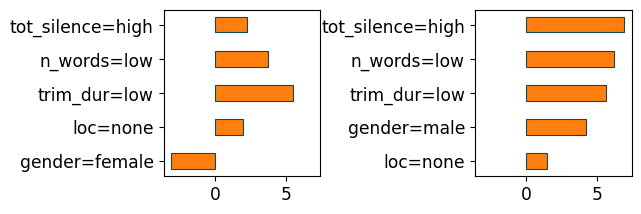

In [69]:
## Plot Shapley Values for the first just-retrieved data subgroup
itemset = comparison_res.loc[0].iloc[0]['Subgroup']

itemset_shaps = []
for gender in genders:
    itemset_0 = itemset.union([gender])
    itemset_shaps.append(fp_divergence_difference.computeShapleyValue(itemset_0))
                
plotComparisonShapleyValues(abbreviateDict(itemset_shaps[0], abbreviations), \
                            abbreviateDict(itemset_shaps[1], abbreviations), \
                            sizeFig=sizeFig, sharedAxis=True, sort="paper", \
                            height = height, saveFig=False, subcaption=False, \
                            labelsize=labelsize, pad=pad) 

## Global Shapley value

In [70]:
## Compute the top-K global shapley values related to the gain in performance between Wav2Vec2-Base and Wav2Vec2-Large
global_item_divergence_w2b_hb = fp_divergence_difference.computeGlobalShapleyValue()

K = 15
topK_global_w2b_hb = {k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(global_item_divergence_w2b_hb, 
                        key=lambda x: abs(global_item_divergence_w2b_hb[x]))[::-1][:K]}

In [71]:
from utils_analysis import plotShapleyValue

sizeFig = (3.2,4)
labelsize = 13
titlesize = 13

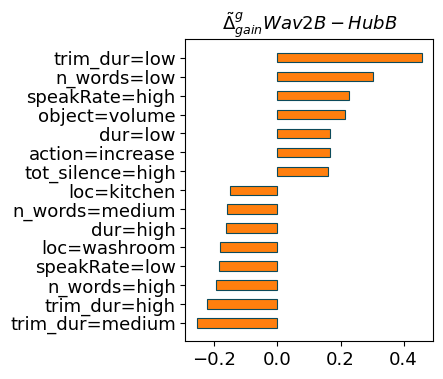

In [72]:
## Plot and Save the Image
topK_global_w2b_hb_abbr = abbreviateDict(topK_global_w2b_hb, abbreviations )
plotShapleyValue(shapley_values=topK_global_w2b_hb_abbr, \
                sizeFig=sizeFig, labelsize=labelsize, titlesize=titlesize, \
                title = r"$\tilde{\Delta}^g_{gain} Wav2B - HubB$", saveFig=False)

In [73]:
## Take the K Global Shapley Values for HubB-WavB starting from the top-K of WavL-WavB
topK_global_w2b_hb_1_abbr = abbreviateDict({k:v for k,v in global_item_divergence_w2b_hb.items() \
                        if k in sorted(topK_global_w2b_w2l)}, abbreviations)

In [76]:
from utils_analysis import plotMultipleSV

name_fig = f"plot_results/global_shapley_gain_w2b_w2l_hb_{K}.pdf"
labelsize = 19
sizeFig = (5, 6.8)
height = 0.35
paper_exp = True

legend = True
if legend:
    name_fig = f"plot_results/global_shapley_gain_w2b_w2l_hb_{K}_legend.pdf"

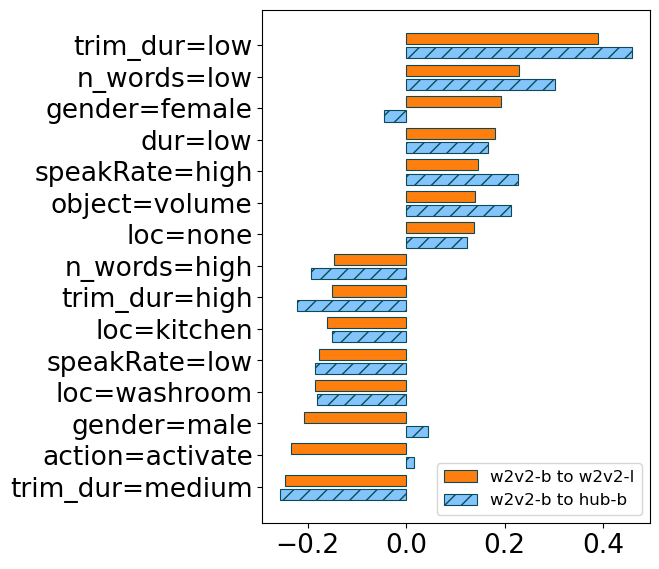

In [77]:
## Plot and Save Image for Global Shapley Value Comparison

plotMultipleSV(shapley_values_1=topK_global_w2b_w2l_abbr, \
            shapley_values_2=topK_global_w2b_hb_1_abbr, \
            paper_exp=paper_exp, labelsize=labelsize, \
            sizeFig=sizeFig, height=height,legend=legend, \
            nameFig=name_fig, saveFig=True)